In [1]:
!mkdir camvid
%cd camvid
!wget https://www.dropbox.com/s/pxcz2wdz04zxocq/CamVid.zip?dl=1 -O CamVid.zip
!unzip -qq CamVid.zip
%cd ..
!unzip -qq "Segmentation Models.zip"

/content/camvid
--2019-12-11 15:59:59--  https://www.dropbox.com/s/pxcz2wdz04zxocq/CamVid.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:6031:1::a27d:5101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/pxcz2wdz04zxocq/CamVid.zip [following]
--2019-12-11 16:00:00--  https://www.dropbox.com/s/dl/pxcz2wdz04zxocq/CamVid.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucdbde20be14e8baebeda7b04e91.dl.dropboxusercontent.com/cd/0/get/AuAd86ga1fiMZO6u3lSowdTwohzquhnrAjG4LYEt-gQbmJIJsef7FjxZRSjR1Bn3RzeR3v117BQD8zWn_tbKxq8KeHhGvRtezmGZ6mNkKZrpvg/file?dl=1# [following]
--2019-12-11 16:00:00--  https://ucdbde20be14e8baebeda7b04e91.dl.dropboxusercontent.com/cd/0/get/AuAd86ga1fiMZO6u3lSowdTwohzquhnrAjG4LYEt-gQbmJIJsef7FjxZRSjR1Bn3RzeR3v117BQD8zWn_tbKxq8KeHhGvRtezmGZ6mNkKZrpvg/file?dl=1
R

In [0]:
import torch
from config import *
from glob import glob
from src.model import *
from src.camvid_pipeline import *
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from matplotlib import pyplot as plt
from torchvision.transforms import ToPILImage

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [0]:
train_images = sorted(glob('./camvid/train/*'))
train_labels = sorted(glob('./camvid/trainannot/*'))
val_images = sorted(glob('./camvid/val/*'))
val_labels = sorted(glob('./camvid/valannot/*'))
test_images = sorted(glob('./camvid/test/*'))
test_labels = sorted(glob('./camvid/testannot/*'))

In [0]:
train_dataset = CamVidDataset(train_images, train_labels, 512, 512)
val_dataset = CamVidDataset(val_images, val_labels, 512, 512)
test_dataset = CamVidDataset(test_images, test_labels, 512, 512)

In [0]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=4)

In [6]:
x_batch, y_batch = next(iter(train_loader))
x_batch.shape, y_batch.shape

(torch.Size([16, 3, 512, 512]), torch.Size([16, 512, 512]))

In [0]:
enet = Enet(12, encoder_relu=True, decoder_relu=True)
enet = enet.to(device)

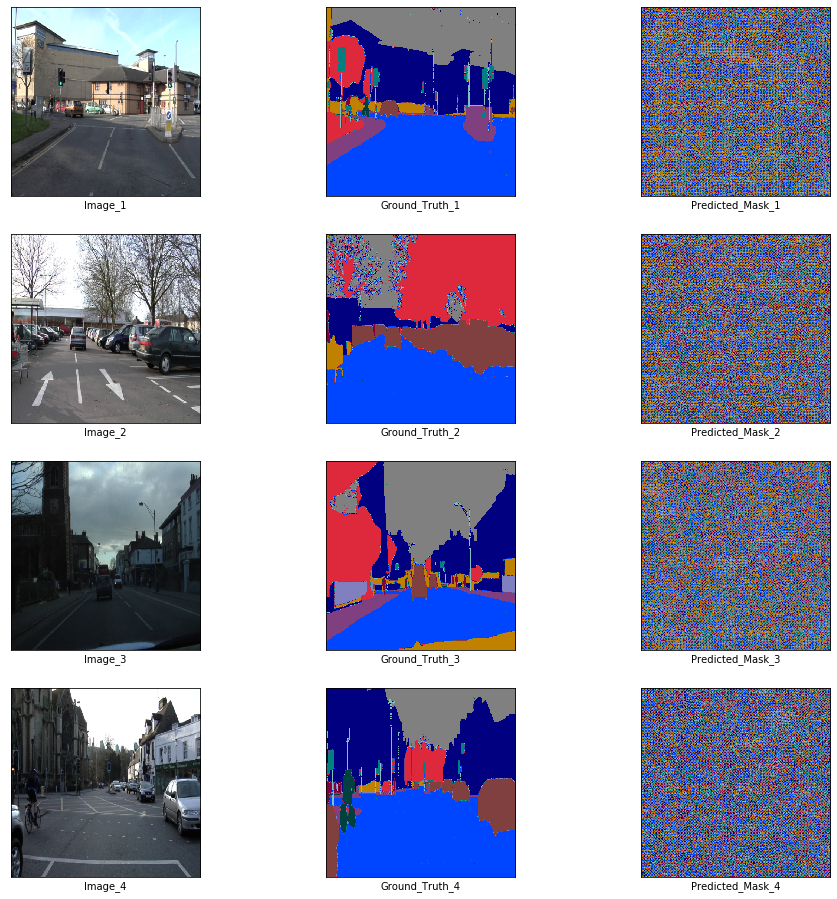

In [8]:
fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize = (16, 16))
plt.setp(axes.flat, xticks = [], yticks = [])
c = 1
for i, ax in enumerate(axes.flat):
    if i % 3 == 0:
        ax.imshow(ToPILImage()(x_batch[c]))
        ax.set_xlabel('Image_' + str(c))
    elif i % 3 == 1:
        ax.imshow(decode_segmap(y_batch[c]))
        ax.set_xlabel('Ground_Truth_' + str(c))
    elif i % 3 == 2:
        ax.imshow(predict_rgb(enet, x_batch[c].unsqueeze(0).to(device)))
        ax.set_xlabel('Predicted_Mask_' + str(c))
        c += 1
plt.show()

In [0]:
criterion = CrossEntropyLoss()
optimizer = Adam(
    enet.parameters(),
    lr=5e-4,
    weight_decay=2e-4
)

In [10]:
train_loss_history, val_loss_history = train(
    enet, train_loader, val_loader,
    device, criterion, optimizer,
    len(train_images) // 16,
    len(val_images) // 16, 5,
    './', 'enet-model', 50
)

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 1



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 2.3417992375113745


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 7.761748790740967
Epoch 2



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 1.9780261354012922


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 8.7780122756958
Epoch 3



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 1.6580684022469954


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 9.014091491699219
Epoch 4



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 1.395627731626684


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 9.40645980834961
Epoch 5



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 1.2247747020287947


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 8.865094184875488
Epoch 6



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 1.1042700084772976


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 8.663503646850586
Epoch 7



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 1.0336108207702637


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 8.431550979614258
Epoch 8



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 0.9722465981136669


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 6.450744152069092
Epoch 9



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 0.9372952336614783


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 6.367807388305664
Epoch 10



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 0.86358858238567


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 3.8445611000061035
Epoch 11



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 0.8445893228054047


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 4.639556407928467
Epoch 12



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 0.8092075857249174


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 1.3490219116210938
Epoch 13



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 0.7790323712609031


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 2.6545820236206055
Epoch 14



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 0.7345240197398446


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 0.4163327217102051
Epoch 15



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 0.7230230136351152


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 3.1398119926452637
Epoch 16



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 0.6776695251464844


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 1.1199955940246582
Epoch 17



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 0.6669504777951674


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 3.5708093643188477
Epoch 18



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 0.6786278513344851


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 2.12918758392334
Epoch 19



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 0.6484400819648396


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 3.044365644454956
Epoch 20



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 0.6231413862921975


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 1.5290553569793701
Epoch 21



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 0.5853204943917014


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 1.172489881515503
Epoch 22



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 0.6038701344620098


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 1.1462526321411133
Epoch 23



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 0.5818723115054044


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 1.6333057880401611
Epoch 24



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 0.5645212517543272


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 1.0769295692443848
Epoch 25



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 0.5480557693676515


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 1.1025145053863525
Epoch 26



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 0.5540069883519952


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 0.8319826126098633
Epoch 27



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 0.5427136868238449


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: -0.0975344181060791
Epoch 28



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 0.5396645069122314


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 0.15387296676635742
Epoch 29



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 0.51048743724823


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: -0.21438813209533691
Epoch 30



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 0.5150939673185349


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: -0.2691080570220947
Epoch 31



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 0.5022442422129891


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 0.4005007743835449
Epoch 32



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 0.5080485371026126


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: -0.4354548454284668
Epoch 33



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 0.49167183312502777


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 0.9936575889587402
Epoch 34



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 0.5028796778483824


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 1.2784931659698486
Epoch 35



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 0.506789272481745


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: -1.5257489681243896
Epoch 36



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 0.5076820660721172


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 0.48480868339538574
Epoch 37



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 0.48112667961554095


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: -2.0523316860198975
Epoch 38



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 0.4706069217486815


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: -1.2762260437011719
Epoch 39



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 0.4703131995417855


  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 0.45615382898937573


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 0.7755887508392334
Epoch 41



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 0.476081058382988


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: -0.6325671672821045
Epoch 42



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 0.4713659896091981


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: -0.220231294631958
Epoch 43



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 0.4468443190509623


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: -1.9909999370574951
Epoch 44



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 0.4530732604590329


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: -0.018846511840820312
Epoch 45



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 0.4457543844526464


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: -0.7409863471984863
Epoch 46



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 0.45676213096488605


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: -1.4892313480377197
Epoch 47



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 0.43224275518547406


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: -1.38602876663208
Epoch 48



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 0.4287408793514425


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: -2.638962984085083
Epoch 49



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 0.4228859123858539


  0%|          | 0/22 [00:00<?, ?it/s]


Validation Loss: 0.193220853805542
Epoch 50



  0%|          | 0/6 [00:00<?, ?it/s]


Training Loss: 0.4294872920621525


100%|██████████| 6/6 [00:19<00:00,  3.31s/it]


Validation Loss: -1.8749217987060547

Training Done.
Training Mean Loss: 0.712017
Validation Mean Loss: 1.904767


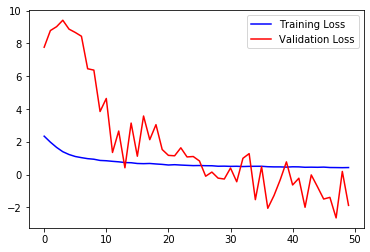

In [11]:
plt.plot(train_loss_history, color = 'b', label = 'Training Loss')
plt.plot(val_loss_history, color = 'r', label = 'Validation Loss')
plt.legend()
plt.show()

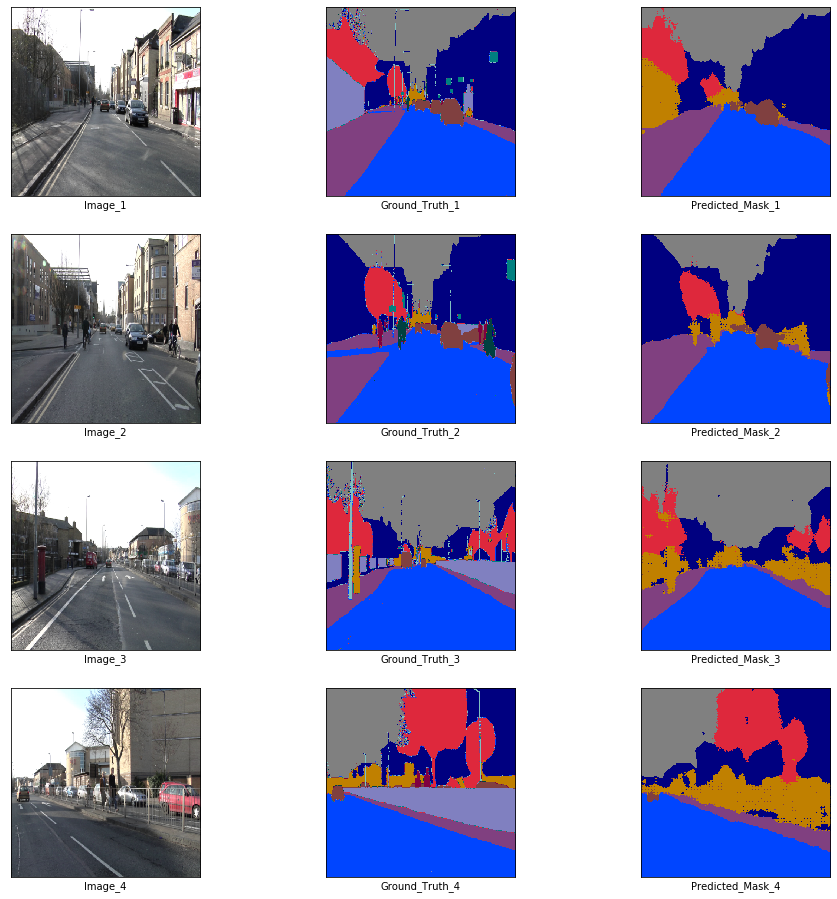

In [12]:
x_batch, y_batch = next(iter(train_loader))
fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize = (16, 16))
plt.setp(axes.flat, xticks = [], yticks = [])
c = 1
for i, ax in enumerate(axes.flat):
    if i % 3 == 0:
        ax.imshow(ToPILImage()(x_batch[c]))
        ax.set_xlabel('Image_' + str(c))
    elif i % 3 == 1:
        ax.imshow(decode_segmap(y_batch[c]))
        ax.set_xlabel('Ground_Truth_' + str(c))
    elif i % 3 == 2:
        ax.imshow(predict_rgb(enet, x_batch[c].unsqueeze(0).to(device)))
        ax.set_xlabel('Predicted_Mask_' + str(c))
        c += 1
plt.show()

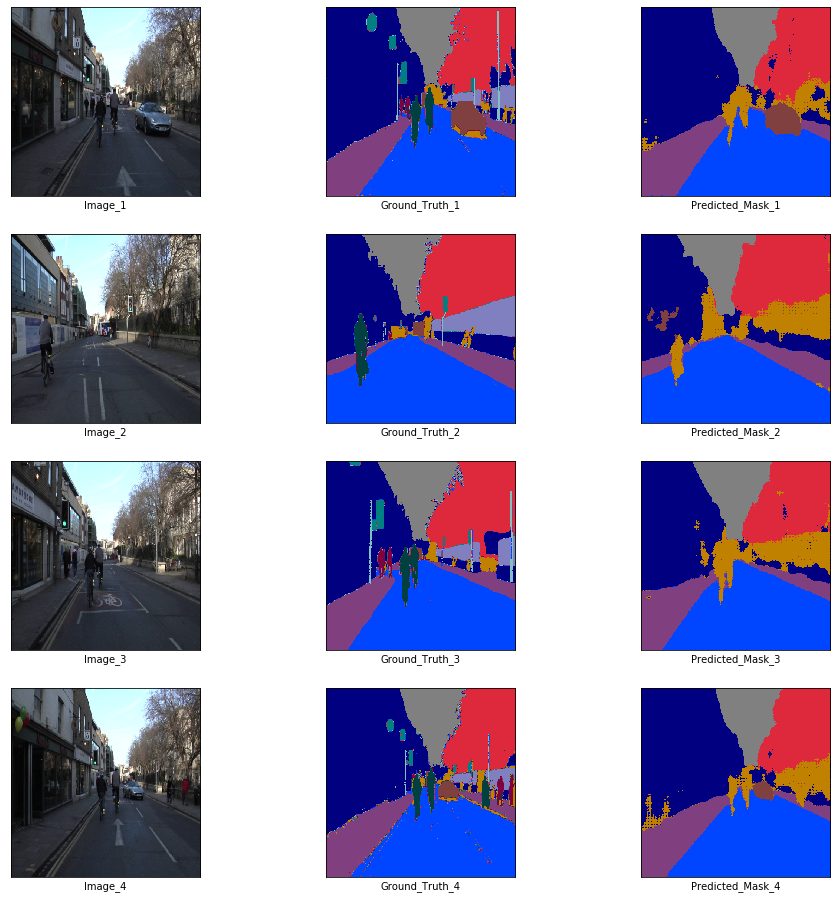

In [13]:
x_batch, y_batch = next(iter(val_loader))
fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize = (16, 16))
plt.setp(axes.flat, xticks = [], yticks = [])
c = 1
for i, ax in enumerate(axes.flat):
    if i % 3 == 0:
        ax.imshow(ToPILImage()(x_batch[c]))
        ax.set_xlabel('Image_' + str(c))
    elif i % 3 == 1:
        ax.imshow(decode_segmap(y_batch[c]))
        ax.set_xlabel('Ground_Truth_' + str(c))
    elif i % 3 == 2:
        ax.imshow(predict_rgb(enet, x_batch[c].unsqueeze(0).to(device)))
        ax.set_xlabel('Predicted_Mask_' + str(c))
        c += 1
plt.show()